C:\Users\FinnKaiser\AppData\Local\Temp\ipykernel_2744\780705408.py:42: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\FinnKaiser\AppData\Local\Temp\ipykernel_2744\780705408.py:52: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Model #0	Score: -27851.12283503429
Model #1	Score: -26982.058803353157
Model #2	Score: -27733.949338215207
Model #3	Score: -28254.138950656627
Model #4	Score: -27677.37069444322
Model #5	Score: -27969.336353367195
Model #6	Score: -28976.87719179582
Model #7	Score: -27902.809888920703
Model #8	Score: -27856.98662616916
Model #9	Score: -27227.088383684757
Model #10	Score: -27874.979020818624
Model #11	Score: -27647.48625548682
Model #12	Score: -27413.140578351504
Model #13	Score: -28260.038616755915
Model #14	Score: -27664.244272839558
Model #15	Score: -27338.893296806968
Model #16	Score: -27824.96825052344
Model #17	Score: -27105.241631549736
Model #18	Score: -26994.827847845474
Model #19	Score: -27069.19326458871
Model #20	Score: -27126.71755051822
Model #21	Score: -27784.756666873724
Model #22	Score: -27055.493149215647
Model #23	Score: -29358.63957175922
Model #24	Score: -27489.835998305945
Model #25	Score: -26978.034129360723
Model #26	Score: -27574.198083845688
Model #27	Score: -27

array([0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667])

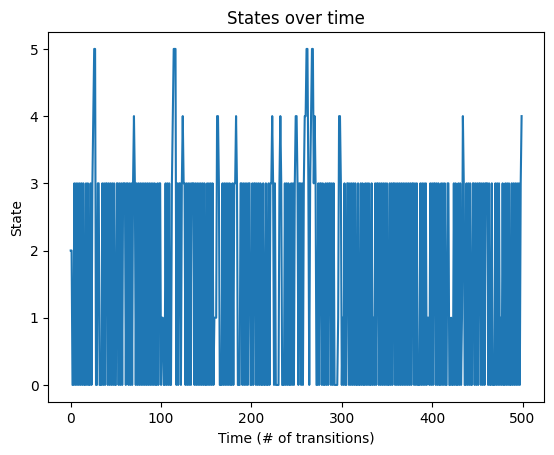

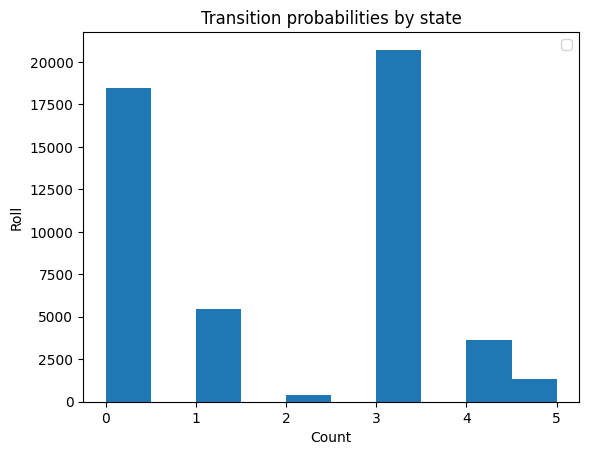

In [24]:
from matplotlib import pyplot as plt
import numpy as np
from hmmlearn import hmm

states = ("S1_o", "S1_d", "S1_u", "S2_o", "S2_d", "S2_u")

generator_model = hmm.CategoricalHMM(n_components=len(states), random_state=42)
initial_state_probabilities = np.array([1.0 if state == "S1_o" else 0.0 for state in states])
initial_state_probabilities = np.array([1/6 for state in states])

with open("dtmc_transitions.txt", "r") as file_content:
    transition_probabilities = np.array(eval(file_content.read()))

emission_probabilities = np.array([
                                            [0.8, 0.2, 0.0, 0.0, 0.0, 0.0],
                                            [0.1, 0.6, 0.1, 0.0, 0.2, 0.0],
                                            [0.0, 0.0, 0.7, 0.0, 0.0, 0.3],
                                            [0.0, 0.0, 0.0, 0.9, 0.1, 0.0],
                                            [0.0, 0.0, 0.0, 0.1, 0.6, 0.3],
                                            [0.2, 0.0, 0.0, 0.1, 0.0, 0.7]])

generator_model.startprob_ = initial_state_probabilities
generator_model.transmat_ = transition_probabilities
generator_model.emissionprob_ = emission_probabilities

generator_result, generator_states = generator_model.sample(50000)

training_data = generator_result[:generator_result.shape[0] // 2]
validation_data = generator_result[generator_result.shape[0] // 2:]

generator_score = generator_model.score(validation_data)

best_score = best_model = None
number_of_fits = 50
np.random.seed(1)

fig, ax = plt.subplots()
ax.plot(generator_states[:500])
ax.set_title('States over time')
ax.set_xlabel('Time (# of transitions)')
ax.set_ylabel('State')
fig.show()

# plot rolls for the fair and loaded states
fig, ax = plt.subplots()
gen_counts, state_ids = np.histogram(generator_result)
ax.hist(state_ids[:-1], state_ids, weights=gen_counts)
ax.set_title('Transition probabilities by state')
ax.set_xlabel('Count')
ax.set_ylabel('Roll')
ax.legend()
fig.show()

for i in range(number_of_fits):
    model = hmm.CategoricalHMM(n_components=len(states), random_state=i)
    model.fit(training_data)
    score = model.score(validation_data)
    print(f'Model #{i}\tScore: {score}')
    if best_score is None or score > best_score:
        best_model = model
        best_score = score

print(f'Generated score: {generator_score}\nBest score:      {best_score}')
initial_state_probabilities

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


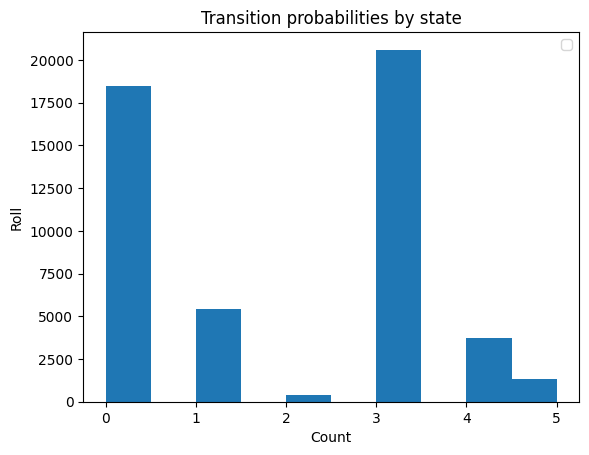

In [25]:
best_model_results, best_model_states = best_model.sample(50000)
fig, ax = plt.subplots()
counts, state_ids = np.histogram(best_model_results)
# counts_gen, state_ids_gen = np.histogram(generator_result)
ax.hist(state_ids[:-1], state_ids, weights=counts)
# ax.hist(state_ids_gen[:-1], state_ids_gen, weights=counts_gen, alpha=0.5)
# plt.hist([counts, counts_gen], state_ids)
ax.set_title('Transition probabilities by state')
ax.set_xlabel('Count')
ax.set_ylabel('Roll')
ax.legend()


The absolute error is 326, the relative error is 0.00652


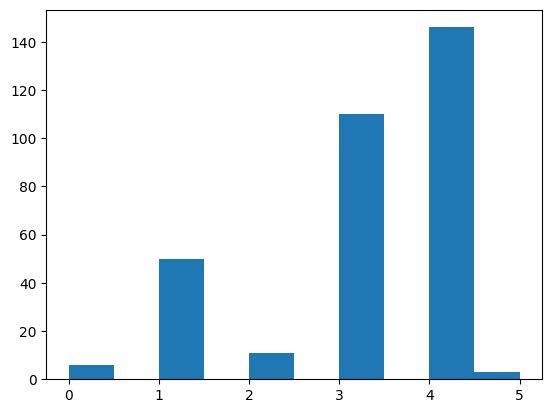

In [26]:
count_difference = abs(gen_counts - counts)
fig, ax = plt.subplots()
# counts_gen, state_ids_gen = np.histogram(generator_result)
ax.hist(state_ids[:-1], state_ids, weights=count_difference)

absolute_error = sum(count_difference)
relative_error = absolute_error / 50000
print(f'The absolute error is {absolute_error}, the relative error is {relative_error}')

In [27]:
states = ("S1_o", "S1_d", "S1_u", "S2_o", "S2_d", "S2_u")


def analyze_model(model_results):
    generated_trace_string = ''.join((str(n[0]) for n in model_results))
    intermittend_failure_c1 = generated_trace_string.count('010') # Intermittend Failure in component 1
    intermittend_failure_c2 = generated_trace_string.count('343') # Intermittend Failure in component 2
    failure_cascade_1 = generated_trace_string.count('245') # Failure cascade
    failure_cascade_2 = generated_trace_string.count('235') # Failure cascade
    failure_masking = generated_trace_string.count('250') # Failure masking

    return intermittend_failure_c1, intermittend_failure_c2, failure_cascade_1, failure_cascade_2, failure_masking

print(analyze_model(best_model_results))
print(analyze_model(generator_result))

generated_trace_string = ''.join((str(n[0]) for n in best_model_results))
generated_trace_string.index('245')
generated_trace_string[4720:4730]

(374, 383, 12, 3, 17)
(302, 356, 4, 1, 19)


'0303103130'